In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# MAP – Charting Student Math Misunderstandings

## 0) Imports, config, and helpers

In [29]:
# ============================================================================
# Imports
# ============================================================================
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import unicodedata
import re
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.optimize import minimize
from tqdm.auto import tqdm
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt, torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import DistilBertTokenizerFast as DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================
def _make_stopwords():
    try:
        from wordcloud import STOPWORDS as WC_STOP
        return set(WC_STOP) | set(ENGLISH_STOP_WORDS)
    except Exception:
        return set(ENGLISH_STOP_WORDS)

def _chunk(lst, n):
    """Yield successive n-sized chunks from list."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def plot_wordclouds_for_whitelist(
    df, text_col="text_norm", label_col="full_label_65",
    label_whitelist=None, out_dir="figs/wc_by_target_65",
    ncols=4, per_page=12, figsize_per_row=4.2
):
    """
    Generate word clouds for a fixed whitelist of labels (keeps order),
    paginated for readability. Skips labels not present in the data.
    Saves each page and each individual cloud.
    """
    from wordcloud import WordCloud
    os.makedirs(out_dir, exist_ok=True)
    stopset = _make_stopwords()

    if label_whitelist is None:
        # Fallback to all observed labels
        label_whitelist = df[label_col].value_counts().index.tolist()

    # Keep only labels that exist in data
    present = [lab for lab in label_whitelist if (df[label_col] == lab).any()]
    if not present:
        print("[WordCloud] None of the requested labels are present in the data.")
        return

    # Paginate
    page = 1
    for labels_page in _chunk(present, per_page):
        n = len(labels_page)
        nrows = int(np.ceil(n / ncols))
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                                 figsize=(ncols*5, nrows*figsize_per_row))
        axes = np.atleast_1d(axes).ravel()

        for i, lab in enumerate(labels_page):
            text = " ".join(df.loc[df[label_col] == lab, text_col].astype(str))
            if len(text.strip()) == 0:
                # no text rows for this label (shouldn't happen due to presence check), skip safely
                axes[i].axis("off"); axes[i].set_title(f"{lab} (no data)"); continue

            wc = WordCloud(width=800, height=400, background_color="white",
                           stopwords=stopset).generate(text)
            axes[i].imshow(wc, interpolation="bilinear")
            axes[i].set_title(str(lab), fontsize=10)
            axes[i].axis("off")
            # save individual image
            safe_name = lab.replace("/", "_").replace(":", "__")
            wc.to_file(f"{out_dir}/wc_{safe_name}.png")

        # turn off any unused subplot slots
        for j in range(i+1, len(axes)):
            axes[j].axis("off")

        plt.suptitle(f"Word Clouds by Category:Misconception — Page {page} (Top 5 most frequence Categories )", y=1.02, fontsize=14)
        plt.tight_layout()
        plt.show()
        fig.savefig(f"{out_dir}/page_{page:02d}.png", dpi=200, bbox_inches="tight")
        page += 1

def plot_overall_wordcloud(df, text_col="text_norm", out_path="figs/wc_overall.png"):
    from wordcloud import WordCloud
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    stopset = _make_stopwords()
    big_text = " ".join(df[text_col].astype(str))
    wc = WordCloud(width=1600, height=800, background_color="white",
                   stopwords=stopset).generate(big_text)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear"); plt.axis("off")
    plt.title("Overall Word Cloud — StudentExplanation (normalized)")
    plt.tight_layout(); plt.show()
    wc.to_file(out_path)
    
# Metric helpers
def topk_from_proba(proba, k=3):
    return np.argsort(-proba, axis=1)[:, :k]

def mapk_score(y_true, topk_idx, k=3):
    hits = (topk_idx == y_true[:, None])
    ranks = np.argmax(hits, axis=1) + 1
    ranks[~hits.any(1)] = 0
    ap = np.where(ranks > 0, 1.0 / ranks, 0.0)
    return float(ap.mean())

def top1_accuracy(y_true, proba): 
    return float((proba.argmax(1) == y_true).mean())

def top3_accuracy(y_true, proba): 
    return float((topk_from_proba(proba, 3) == y_true[:, None]).any(axis=1).mean())

def mean_average_precision_at_3(y_true, proba):
    """Compute Mean Average Precision at k=3."""
    k = 3
    sorted_indices = np.argsort(-proba, axis=1)[:, :k]
    aps = []
    
    for i in range(len(y_true)):
        y_true_i = y_true[i]
        preds = sorted_indices[i]
        relevant = (preds == y_true_i)
        
        if not np.any(relevant):
            aps.append(0.0)
            continue
        
        pos = np.where(relevant)[0][0] + 1
        precisions = np.cumsum(relevant) / np.arange(1, k + 1)
        ap = np.sum(precisions * relevant) / 1.0
        aps.append(ap)
    
    return np.mean(aps)

def ensemble_objective(weights, proba_list, y_true):
    """Objective function to minimize (negative MAP@3)."""
    weights = weights / weights.sum()
    proba_ensemble = sum(w * p for w, p in zip(weights, proba_list))
    map3 = mean_average_precision_at_3(y_true, proba_ensemble)
    return -map3

## 1- Data Loading and Preprocessing :   build target, normalize text, stratified split

In [3]:
# Load data
train = pd.read_csv("C:/Users/User/anaconda3/envs/capstone_sup_unsup/train.csv")
test = pd.read_csv("C:/Users/User/anaconda3/envs/capstone_sup_unsup/test.csv")

# Combine Category and Misconception as full label string (target)
train["full_label"] = train["Category"].astype(str) + ":" + train["Misconception"].astype(str)
CAT_COL = "Category"
MIS_COL = "Misconception"

# Math-aware text normalization
def normalize_math_text(s):
    if not isinstance(s, str): 
        return ""
    s = unicodedata.normalize("NFKC", s).lower()
    s = re.sub(r"[^a-z0-9\./]+", " ", s)
    s = re.sub(r"\s{2,}", " ", s).strip()
    return s

train["text_norm"] = train["StudentExplanation"].apply(normalize_math_text)
test["text_norm"]  = test["StudentExplanation"].apply(normalize_math_text)

# ✅ Create 'label_id' BEFORE splitting into freq_df and rare_df
classes = sorted(train["full_label"].unique())
cls2id = {c: i for i, c in enumerate(classes)}
train["label_id"] = train["full_label"].map(cls2id)
y = train["label_id"].values  # Full labels

# Split out rare classes (those with only 1 example)
counts = train["full_label"].value_counts()
is_rare = train["full_label"].map(counts) == 1
freq_df = train[~is_rare].copy()
rare_df = train[is_rare].copy()

# Now it's safe to use 'label_id' in freq_df and rare_df
X_freq = freq_df["text_norm"].values
y_freq = freq_df["label_id"].values  # Already exists now

# Stratified split for frequent classes
X_tr, X_val, y_tr, y_val = train_test_split(
    X_freq, y_freq, test_size=0.20, random_state=42, stratify=y_freq)

# Combine rare examples into training set
X_train = np.concatenate([X_tr, rare_df["text_norm"].values])
y_train = np.concatenate([y_tr, rare_df["label_id"].values])  # Now works!

## 3- TF-IDF + XGBoost Model

### 3-1 TF-IDF Feature Engineering

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Custom token pattern to keep words, decimals and fractions
token_pattern = r"(?u)\b\w+\b|\b\d+\.\d+\b|\b\d+/\d+\b"
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=60000,
    min_df=2,
    token_pattern=token_pattern
)
X_tr_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(test["text_norm"].values)
print("TF-IDF features:", X_tr_tfidf.shape, "| Vocab size:", len(tfidf.vocabulary_))


TF-IDF features: (29396, 22957) | Vocab size: 22957


###  3-2 A Priori text analysis + Word Clouds


In [ ]:
!pip install wordcloud xgboost 

[WordCloud] Top-5 labels: ['True_Correct:nan', 'False_Neither:nan', 'True_Neither:nan', 'False_Misconception:Incomplete', 'False_Misconception:Additive']


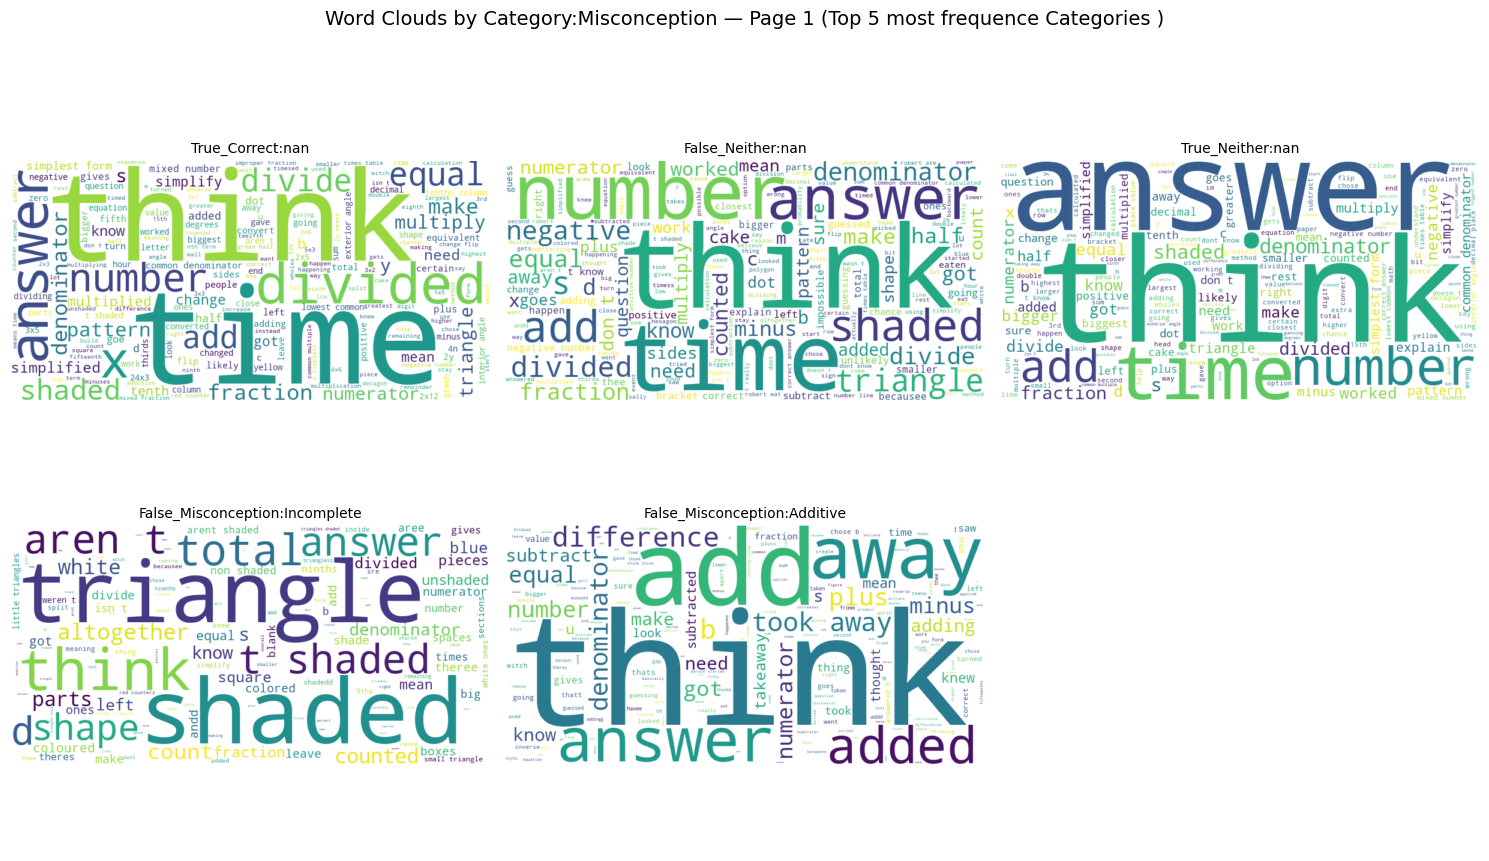

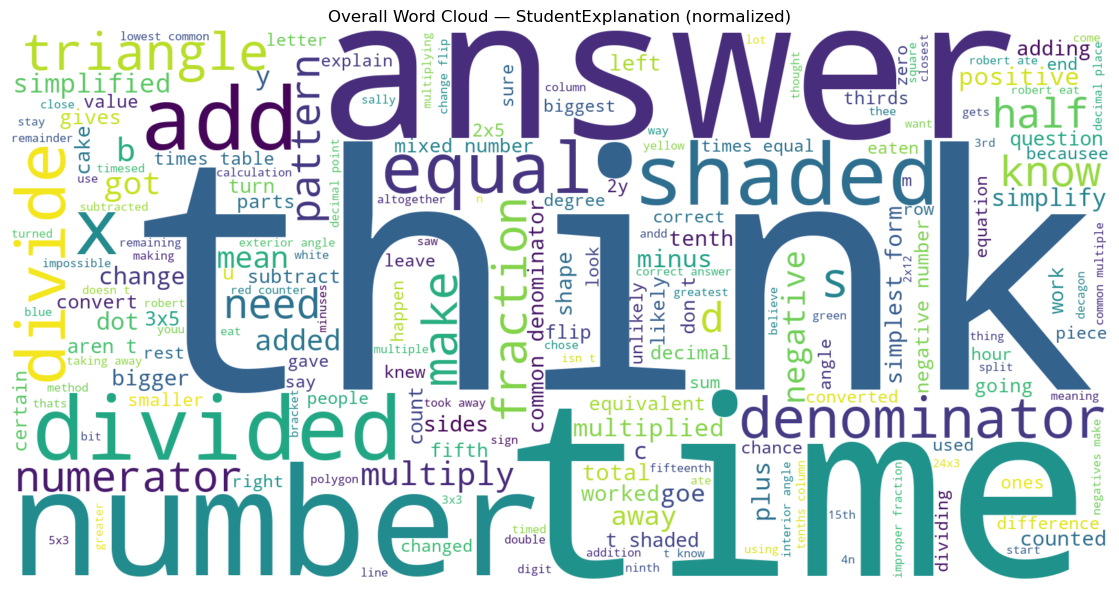

In [8]:
# ============================
#  Exploratory analysis + Word Clouds
#    - per Target (Category:Misconception) across ALL 65 labels (':nan' style)
#    - overall on StudentExplanation text
# ============================

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# If not already present 
# train["text_norm"]  = train[TEXT_COL].apply(normalize_math_text)

# --- Build a plotting-only label column that matches your requested 65-label style (':nan' for missing) ---
def make_full_label_65(row):
    cat = str(row.get(CAT_COL, ""))
    mis = row.get(MIS_COL, np.nan)
    mis_str = str(mis) if pd.notna(mis) else "nan"
    return f"{cat}:{mis_str}"

train = train.copy()
train["full_label_65"] = train.apply(make_full_label_65, axis=1)

# --- Your exact 65 categories (whitelist & ordering) ---
TARGET_65 = classes 


# --- run the plots ---
# --- visualize only the 5 most frequent labels within TARGET_65 ---

# Count frequencies on the plotting label
label_counts = train["full_label_65"].value_counts()

# Keep only labels that are in TARGET_65 and present in data
present = [lab for lab in TARGET_65 if lab in label_counts.index]

# Pick the top 5 by frequency
top5 = sorted(present, key=lambda lab: label_counts[lab], reverse=True)[:5]
print("[WordCloud] Top-5 labels:", top5)

# Plot word clouds for just these 5 labels (1 page)
plot_wordclouds_for_whitelist(
    train,
    text_col="text_norm",
    label_col="full_label_65",
    label_whitelist=top5,
    out_dir="figs/wc_by_target_65_top5",
    ncols=min(3, len(top5)),  # nice compact layout
    per_page=5,               # ensure all on one page
    figsize_per_row=4.2
)

# B) Overall Word Cloud on the explanation text (global patterns)
plot_overall_wordcloud(train, text_col="text_norm", out_path="figs/wc_overall.png")

### 3-3 Top TF-IDF terms — only 6 most frequent classes

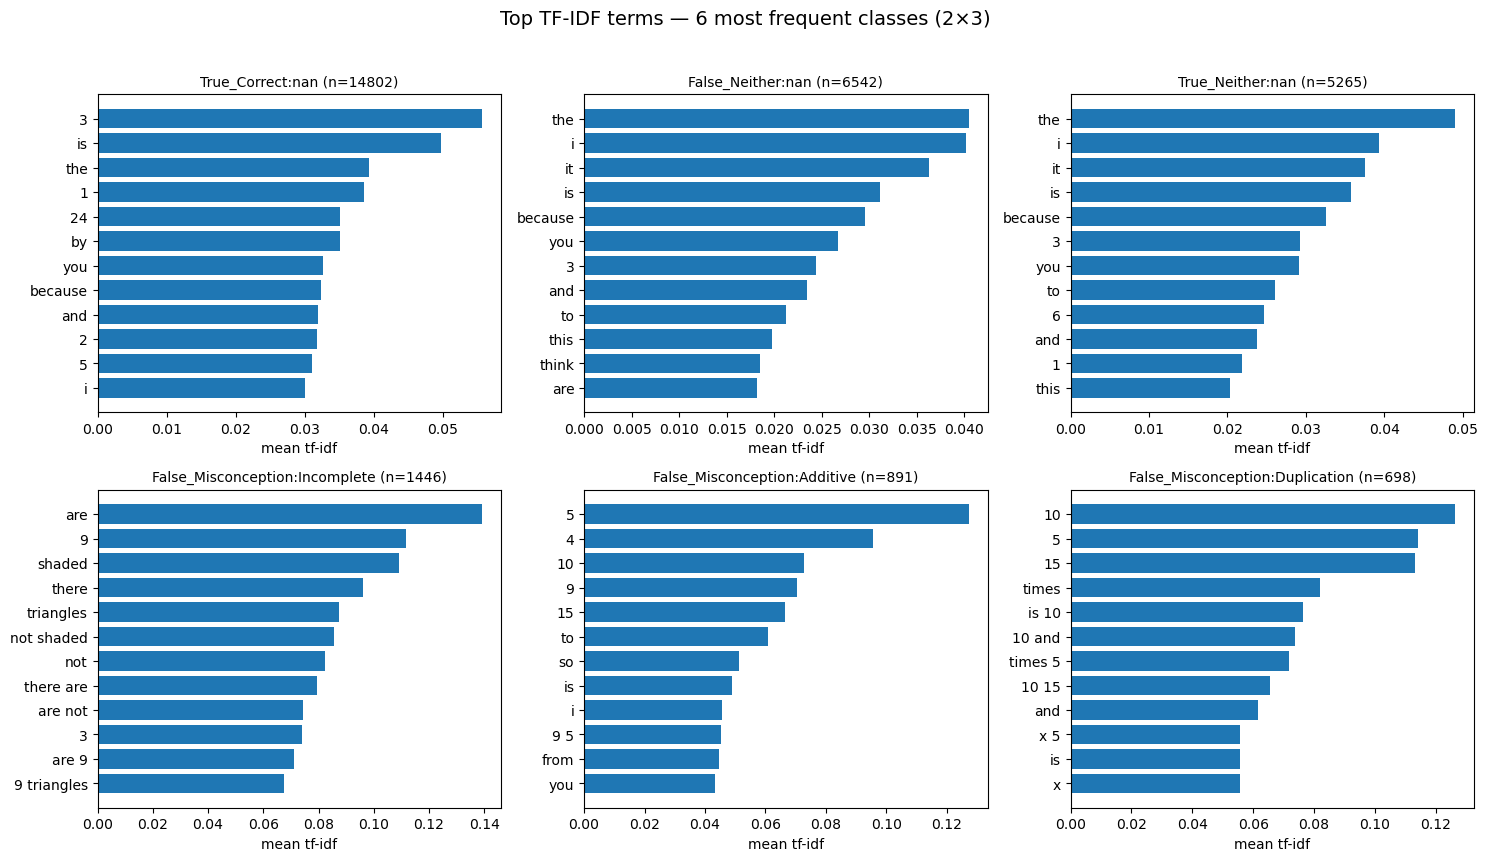

In [9]:
# ============================
# Top TF-IDF terms — only 6 most frequent classes (2 rows x 3 cols)
# ============================
#  Create the necessary mapping dictionaries
id2cls = {i: cls for i, cls in enumerate(classes)}  # For the function's 'id2cls' parameter
cls2id = {cls: i for i, cls in enumerate(classes)}  # For the 'freq_df' mapping

# Apply the mapping to your dataframe to create numeric labels
# This assumes 'freq_df' has a column 'full_label' with the string class names
freq_df['label_id'] = freq_df['full_label'].map(cls2id)

def top_tfidf_by_top_classes(
    texts,
    labels,
    vectorizer,
    id2cls,                          # dict: class_id -> "Category:Misconception"
    top_n_classes=6,
    k=12,                            # top-k terms per class
    save_path="figs/top_tfidf/top6_grid.png"
):
    import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Vectorize (assumes vectorizer is already fitted)
    X = vectorizer.transform(texts)

    # Count class frequencies and pick top N
    counts = pd.Series(labels).value_counts()
    top_labs = counts.head(top_n_classes).index.tolist()

    # Inverse vocab to map column index -> token
    inv_vocab = {i: w for w, i in vectorizer.vocabulary_.items()}

    # Prepare grid 2x3
    nrows, ncols = 2, 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 4.2))
    axes = np.atleast_1d(axes).ravel()

    for ax_idx in range(nrows * ncols):
        ax = axes[ax_idx]
        if ax_idx >= len(top_labs):
            ax.axis("off")
            continue

        lab = int(top_labs[ax_idx])
        mask = (labels == lab)
        cnt = int(mask.sum())
        if cnt == 0:
            ax.axis("off")
            continue

        # Mean TF-IDF vector for the class
        mean_vec = X[mask].mean(axis=0).A1
        top_idx = mean_vec.argsort()[::-1][:k]
        words   = [inv_vocab[i] for i in top_idx]
        vals    = mean_vec[top_idx]

        ax.barh(range(k), vals[::-1])
        ax.set_yticks(range(k))
        ax.set_yticklabels(words[::-1])
        ax.set_xlabel("mean tf-idf")
        title = f"{id2cls[lab][:48]} (n={cnt})"
        ax.set_title(title, fontsize=10)

    plt.suptitle("Top TF-IDF terms — 6 most frequent classes (2×3)", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()
    fig.savefig(save_path, dpi=200, bbox_inches="tight")

    # Return the human-readable class names plotted (optional)
    return [id2cls[int(l)] for l in top_labs]

# ---- Run on your frequent split from §2.1 (uses the same tfidf and mappings) ----
# labels must be numeric class ids, e.g. freq_df["full_label"].map(cls2id).values
_ = top_tfidf_by_top_classes(
    texts=freq_df["text_norm"].values,
    labels=freq_df["full_label"].map(cls2id).values,
    vectorizer=tfidf,
    id2cls=id2cls,
    top_n_classes=6,
    k=12,
    save_path="figs/top_tfidf/top6_grid.png"
)


### 3-4 Training XGBoost

In [10]:
import xgboost as xgb
import time 

# Compute class weights inversely proportional to frequency
freq = np.bincount(y_train)
class_weight = {i: sum(freq)/freq[i] for i in range(len(freq))}

xgb_clf = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=len(classes),
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    enable_categorical=True,
    eval_metric="mlogloss",
    scale_pos_weight=None  # we use sample weights instead
)
# Fit with sample weights

weights = np.array([class_weight[y] for y in y_train])
start_time = time.time()
xgb_clf.fit(X_tr_tfidf, y_train, sample_weight=weights)
proba_val_xgb = xgb_clf.predict_proba(X_val_tfidf)
end_time = time.time()
elapsed = end_time - start_time

# Performance metrics
print(f"[XGB] Top-1 Accuracy: {top1_acc(y_val, proba_val_xgb):.4f}")
print(f"[XGB] Top-3 Accuracy: {top3_acc(y_val, proba_val_xgb):.4f}")
print(f"[XGB] Training Time: {elapsed:.1f}s")

[XGB] Top-1 Accuracy: 0.7049
[XGB] Top-3 Accuracy: 0.9459
[XGB] Training Time: 2066.1s


### 3-5 Evaluation of TF-IDF + XGBoost

XGB (TF-IDF) val: MAP@3=0.8136, Top-1=0.7049, Top-3=0.9459


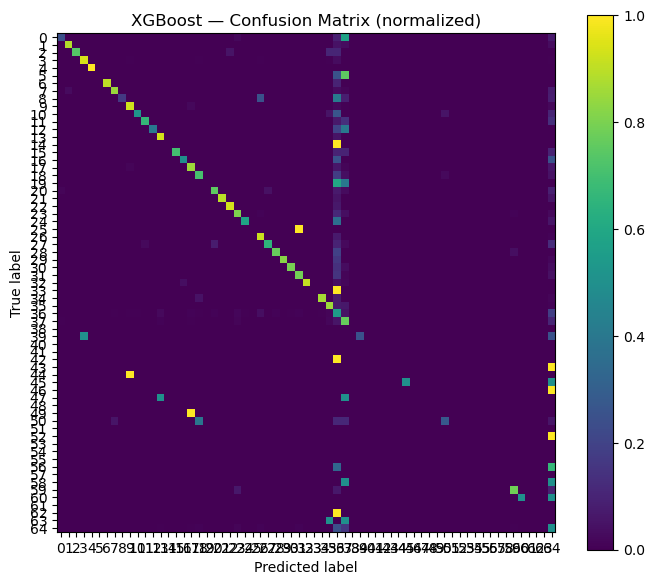

In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# Functions for metrics
def topk_accuracy(y_true, proba, k=3):
    if proba.shape[0] == 0: return 0.0
    topk = np.argsort(proba, axis=1)[:, -k:]
    return float((topk == y_true.reshape(-1,1)).any(axis=1).mean())

def map3_score(y_true, proba):
    if proba.size == 0: return 0.0
    ap_scores = []
    # for each example
    for i, p in enumerate(proba):
        top3 = np.argsort(p)[::-1][:3]
        if y_true[i] in top3:
            rank = list(top3).index(y_true[i]) + 1
            ap_scores.append(1.0/rank)
        else:
            ap_scores.append(0.0)
    return np.mean(ap_scores)

y_val = y_val.astype(int)
map3_xgb = map3_score(y_val, proba_val_xgb)
acc1_xgb = np.mean(y_val == proba_val_xgb.argmax(axis=1))
acc3_xgb = topk_accuracy(y_val, proba_val_xgb, k=3)
print(f"XGB (TF-IDF) val: MAP@3={map3_xgb:.4f}, Top-1={acc1_xgb:.4f}, Top-3={acc3_xgb:.4f}")

# Confusion matrix

cm = confusion_matrix(y_val, proba_val_xgb.argmax(axis=1), labels=np.arange(len(classes)), normalize="true")
fig, ax = plt.subplots(figsize=(7,6))
ConfusionMatrixDisplay(cm).plot(include_values=False, ax=ax)
ax.set_title("XGBoost — Confusion Matrix (normalized)")
plt.tight_layout(); plt.show()

## 4- DistilBERT Fine-tuning

[BERT] Device: cpu


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...
[Ep 1] train loss 2.1177 acc 0.4335 | val loss 1.2289 acc 0.5858 MAP@3 0.7119
[Ep 2] train loss 1.1399 acc 0.6415 | val loss 1.0171 acc 0.6753 MAP@3 0.7919
[Ep 3] train loss 0.8235 acc 0.7055 | val loss 0.9815 acc 0.6963 MAP@3 0.8089
[Ep 4] train loss 0.6437 acc 0.7520 | val loss 1.0741 acc 0.7272 MAP@3 0.8339
[Ep 5] train loss 0.5227 acc 0.7892 | val loss 1.0414 acc 0.7355 MAP@3 0.8391

Loading best model for final evaluation...

[BERT] Final Performance:
  Accuracy:  0.7355
  MAP@3:     0.8391
  Top-1 Acc: 0.7355
  Top-3 Acc: 0.9606


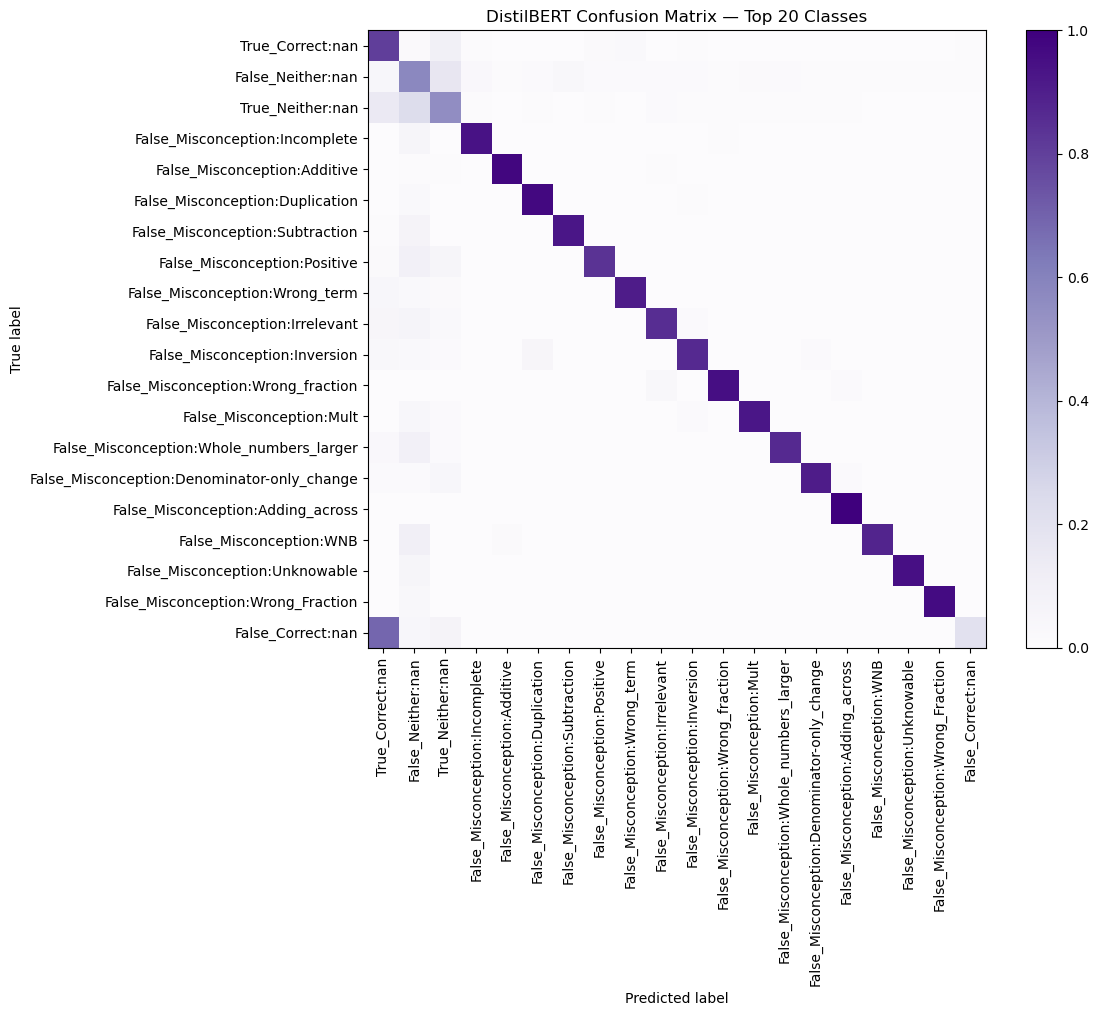

✅ Training and evaluation complete!
✅ Confusion matrix saved: visualizations/bert_confusion_matrix_top20.png


In [30]:
# ============================================================================
# CONFIGURATION & SETUP
# ============================================================================

# Label mapping
idx_to_class = {i: c for i, c in enumerate(classes)}

# Hyperparameters
MAX_LENGTH = 192
BATCH_SIZE = 16
TRANSFORMER_LR = 3e-5
TRANSFORMER_EPOCHS = 5
MODEL_NAME = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[BERT] Device: {device}")

# ============================================================================
# DATA PREPARATION
# ============================================================================

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

class MathMisconceptionDS(Dataset):
    def __init__(self, texts, labels=None, max_len=MAX_LENGTH):
        self.texts = list(texts)
        self.labels = None if labels is None else np.asarray(labels, dtype=np.int64)
        self.max_len = max_len
    
    def __len__(self): 
        return len(self.texts)
    
    def __getitem__(self, i):
        enc = tokenizer(self.texts[i], max_length=self.max_len, truncation=True, 
                       padding="max_length", return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

# Create datasets and loaders
train_ds = MathMisconceptionDS(X_train, y_train)
val_ds = MathMisconceptionDS(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ============================================================================
# MODEL INITIALIZATION
# ============================================================================

model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(classes))
model.to(device)

# Class-weighted loss for imbalance handling
freq = np.bincount(y_train, minlength=len(classes))
invw = (freq.sum() / np.maximum(freq, 1)).astype(np.float32)
class_weights = torch.tensor(invw, dtype=torch.float32, device=device)

optimizer = AdamW(model.parameters(), lr=TRANSFORMER_LR)
total_steps = len(train_loader) * TRANSFORMER_EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
ce = torch.nn.CrossEntropyLoss(weight=class_weights)

# ============================================================================
# TRAINING LOOP
# ============================================================================

def train_epoch():
    model.train()
    losses, correct, n = [], 0, 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        out = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = out.logits
        loss = ce(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        n += labels.size(0)
    return float(np.mean(losses)), correct / max(1, n)

@torch.no_grad()
def eval_epoch(loader):
    model.eval()
    losses, correct, n = [], 0, 0
    all_probs, all_labels = [], []
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        out = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = out.logits
        loss = ce(logits, labels)

        losses.append(loss.item())
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        n += labels.size(0)

        probs = torch.softmax(logits, dim=1).cpu().numpy()
        all_probs.append(probs)
        all_labels.append(labels.cpu().numpy())

    proba = np.concatenate(all_probs, axis=0) if all_probs else np.zeros((0, len(classes)))
    labels = np.concatenate(all_labels, axis=0) if all_labels else np.zeros((0,), dtype=int)
    return float(np.mean(losses)), correct / max(1, n), proba, labels

# Training
best_acc, best_path = 0.0, "best_distilbert.bin"
print("Starting training...")
for ep in range(1, TRANSFORMER_EPOCHS + 1):
    tr_loss, tr_acc = train_epoch()
    va_loss, va_acc, va_proba, va_y = eval_epoch(val_loader)
    va_map3 = mapk_score(va_y, topk_from_proba(va_proba, 3), 3)
    print(f"[Ep {ep}] train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f} MAP@3 {va_map3:.4f}")
    if va_acc > best_acc:
        best_acc = va_acc
        torch.save(model.state_dict(), best_path)

# ============================================================================
# FINAL EVALUATION
# ============================================================================

print("\nLoading best model for final evaluation...")
model.load_state_dict(torch.load(best_path, map_location=device))
val_loss, val_acc, proba_va_bert, y_val_bert = eval_epoch(val_loader)
val_map3_bert = mapk_score(y_val_bert, topk_from_proba(proba_va_bert, 3), 3)

print(f"\n[BERT] Final Performance:")
print(f"  Accuracy:  {val_acc:.4f}")
print(f"  MAP@3:     {val_map3_bert:.4f}")
print(f"  Top-1 Acc: {top1_accuracy(y_val_bert, proba_va_bert):.4f}")
print(f"  Top-3 Acc: {top3_accuracy(y_val_bert, proba_va_bert):.4f}")

# ============================================================================
# CONFUSION MATRIX VISUALIZATION
# ============================================================================

os.makedirs("visualizations", exist_ok=True)

# Top-20 classes confusion matrix
pred1_bert = proba_va_bert.argmax(1)
val_counts = np.bincount(y_val_bert, minlength=len(classes))
top20 = val_counts.argsort()[::-1][:20]
mask = np.isin(y_val_bert, top20)

cm_top20 = confusion_matrix(y_val_bert[mask], pred1_bert[mask], labels=top20, normalize='true')
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay(cm_top20, display_labels=[idx_to_class[i] for i in top20]).plot(
    include_values=False, cmap="Purples", ax=ax, xticks_rotation=90)
ax.set_title("DistilBERT Confusion Matrix — Top 20 Classes")
plt.tight_layout()
plt.savefig("visualizations/bert_confusion_matrix_top20.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Training and evaluation complete!")
print("✅ Confusion matrix saved: visualizations/bert_confusion_matrix_top20.png")

## 6-Ensembling Model XGBoost + DistilBert 

OPTIMIZED WEIGHTED ENSEMBLE: XGBoost + DistilBERT
Optimizing ensemble weights...
Optimized weights - XGBoost: 0.4147, DistilBERT: 0.5853

📊 Ensemble Performance:
   XGBoost MAP@3:     0.8136
   DistilBERT MAP@3:  0.8393
   Ensemble MAP@3:    0.8437
   Improvement:       +0.0045

[Ensemble] CLASSIFICATION REPORT - TOP 20 CLASSES:
                                             precision    recall  f1-score   support

                          False_Correct:nan     0.4375    0.3111    0.3636        45
          False_Misconception:Adding_across     0.8000    0.9836    0.8824        61
           False_Misconception:Adding_terms     0.0000    0.0000    0.0000         0
               False_Misconception:Additive     0.9454    0.9719    0.9584       178
              False_Misconception:Base_rate     0.0000    0.0000    0.0000         0
             False_Misconception:Definition     0.0000    0.0000    0.0000         0
False_Misconception:Denominator-only_change     0.7595    0.9091    0.827

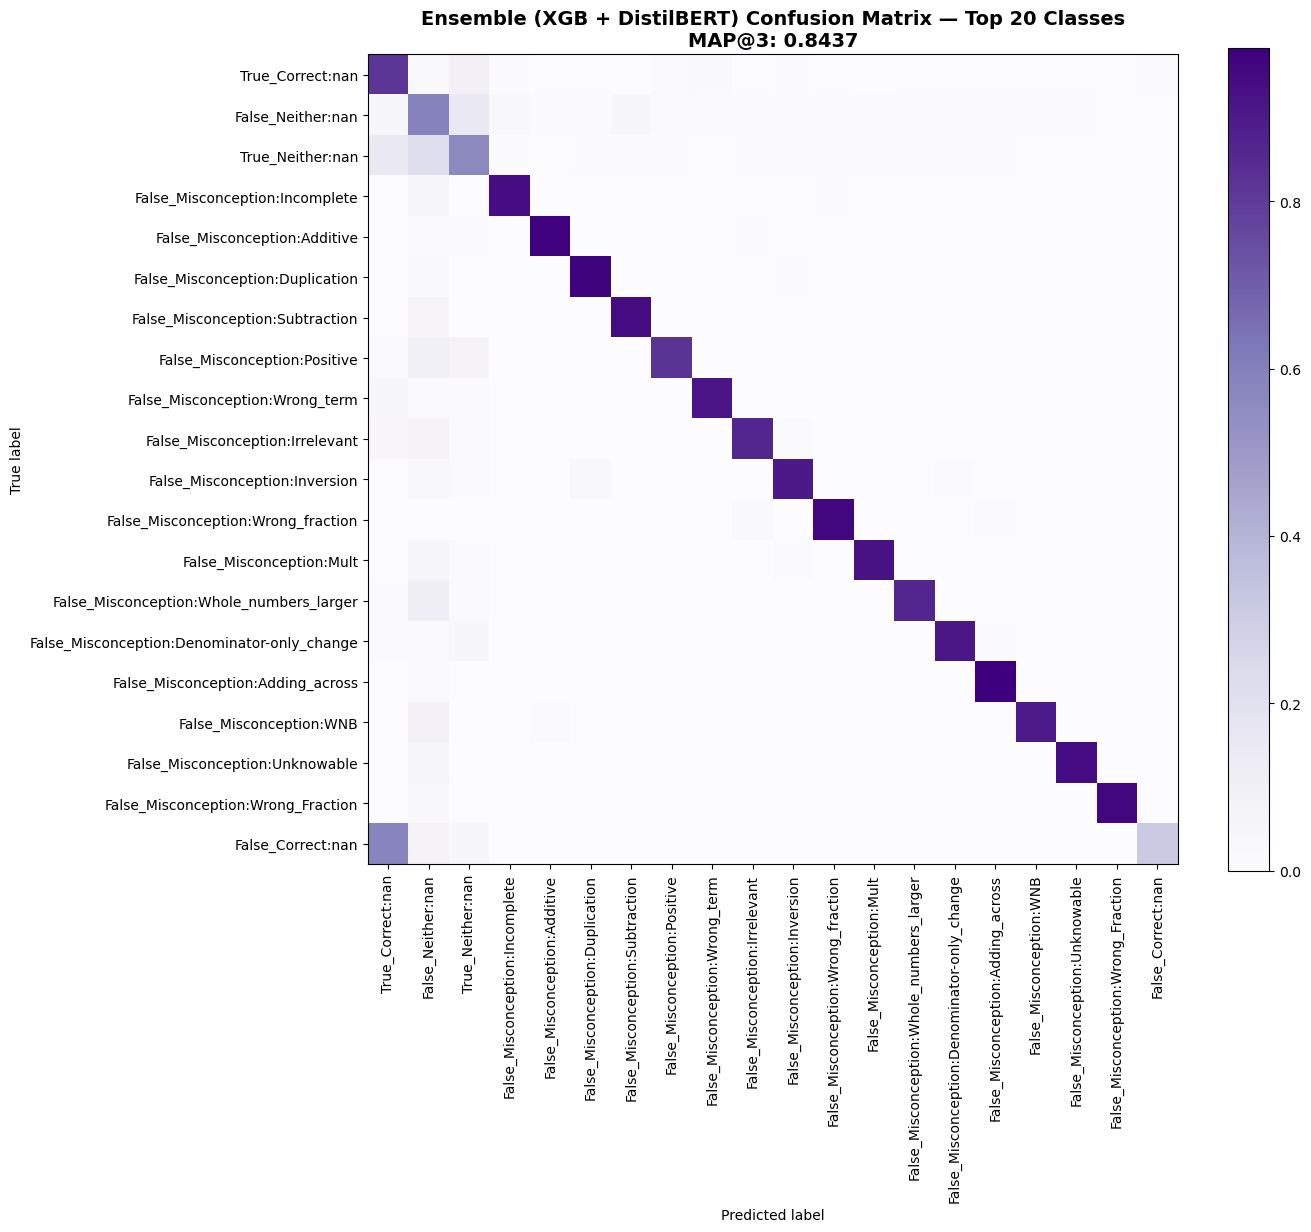


GENERATING TEST SET PREDICTIONS
[1/2] Generating XGBoost predictions...
[2/2] Generating DistilBERT predictions...


DistilBERT inference:   0%|          | 0/1 [00:00<?, ?it/s]


[Ensemble] Combining predictions with optimized weights

✅ Submission file saved to: submission_ensemble.csv
   Shape: (3, 2)

Sample predictions:
   row_id                             Category:Misconception
0   36696  True_Correct:nan True_Neither:nan False_Neithe...
1   36697  False_Misconception:WNB False_Misconception:In...
2   36698  True_Neither:nan True_Correct:nan False_Neithe...

✅ ENSEMBLE PIPELINE COMPLETE!


In [41]:
# ============================================================================
# OPTIMIZED WEIGHTED ENSEMBLE: XGBoost + DistilBERT
# ============================================================================
print("="*80)
print("OPTIMIZED WEIGHTED ENSEMBLE: XGBoost + DistilBERT")
print("="*80)

# Optimize weights
print("Optimizing ensemble weights...")
sample_size = min(5000, len(y_val))
np.random.seed(42)
sample_idx = np.random.choice(len(y_val), sample_size, replace=False)

proba_list_sample = [proba_va_xgb[sample_idx], proba_va_bert[sample_idx]]
y_val_sample = y_val[sample_idx]

result = minimize(
    ensemble_objective,
    [0.5, 0.5],
    args=(proba_list_sample, y_val_sample),
    bounds=[(0, 1), (0, 1)],
    method='Nelder-Mead'
)

opt_weights = result.x / result.x.sum()
print(f"Optimized weights - XGBoost: {opt_weights[0]:.4f}, DistilBERT: {opt_weights[1]:.4f}")

# Validation performance
proba_ensemble_opt = opt_weights[0] * proba_va_xgb + opt_weights[1] * proba_va_bert
map3_opt = mean_average_precision_at_3(y_val, proba_ensemble_opt)

print(f"\n📊 Ensemble Performance:")
print(f"   XGBoost MAP@3:     {map3_xgb:.4f}")
print(f"   DistilBERT MAP@3:  {map3_bert:.4f}")
print(f"   Ensemble MAP@3:    {map3_opt:.4f}")
print(f"   Improvement:       +{map3_opt - max(map3_xgb, map3_bert):.4f}")
# ============================================================================
# VISUALIZATION: Ensemble Confusion Matrix for the Top 20
# ============================================================================
non_zero_classes = np.where(val_counts > 0)[0]
top20_indices = non_zero_classes[val_counts[non_zero_classes].argsort()[::-1][:20]]
val_counts = np.bincount(y_val, minlength=len(classes))


# Filter for samples that belong to top 20 classes
mask = np.isin(y_val, top20_indices)
y_val_filtered = y_val[mask]
pred_ensemble_filtered = proba_ensemble_opt.argmax(1)[mask]

print(f"\n[Ensemble] CLASSIFICATION REPORT - TOP 20 CLASSES:")
print(classification_report(
    [idx_to_class[i] for i in y_val_filtered],
    [idx_to_class[i] for i in pred_ensemble_filtered], 
    digits=4
))

# Confusion Matrix
cm_ensemble = confusion_matrix(
    y_val_filtered, 
    pred_ensemble_filtered,
    labels=top20_indices,
    normalize="true"
)

fig, ax = plt.subplots(figsize=(14, 12))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_ensemble,
    display_labels=[idx_to_class[i] for i in top20_indices]
)
disp.plot(include_values=False, cmap="Purples", ax=ax, xticks_rotation=90)
ax.set_title(f"Ensemble (XGB + DistilBERT) Confusion Matrix — Top 20 Classes\nMAP@3: {map3_opt:.4f}", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("visualizations/ensemble_cm_top20.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# GENERATE TEST SET PREDICTIONS
# ============================================================================

print("\n" + "="*80)
print("GENERATING TEST SET PREDICTIONS")
print("="*80)

# XGBoost test predictions
print("[1/2] Generating XGBoost predictions...")
if 'X_test_tfidf' in globals():
    proba_te_xgb = xgb_clf.predict_proba(X_test_tfidf)
elif 'X_te' in globals():
    proba_te_xgb = xgb_clf.predict_proba(X_te)
else:
    raise NameError("Test TF-IDF features not found")

# DistilBERT test predictions  
print("[2/2] Generating DistilBERT predictions...")
te_ds = MathMisconceptionDS(test["text_norm"], labels=None)
te_dl = DataLoader(te_ds, batch_size=BATCH_SIZE, shuffle=False)

model.eval()
proba_te_bert_list = []

with torch.no_grad():
    for batch in tqdm(te_dl, desc="DistilBERT inference"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
        proba_te_bert_list.append(probs)

proba_te_bert = np.concatenate(proba_te_bert_list, axis=0)

# Ensemble test predictions
print(f"\n[Ensemble] Combining predictions with optimized weights")
proba_te_ensemble = opt_weights[0] * proba_te_xgb + opt_weights[1] * proba_te_bert

# Create submission
top3_preds_te = np.argsort(-proba_te_ensemble, axis=1)[:, :3]
top3_classes_te = [[idx_to_class[idx] for idx in row] for row in top3_preds_te]

if 'row_id' in test.columns:
    id_col = test['row_id']
else:
    id_col = test.index

submission = pd.DataFrame({
    'row_id': id_col,
    'Category:Misconception': [' '.join(classes) for classes in top3_classes_te]
})

submission_path = "submission_ensemble.csv"
submission.to_csv(submission_path, index=False)
print(f"\n✅ Submission file saved to: {submission_path}")
print(f"   Shape: {submission.shape}")
print(f"\nSample predictions:")
print(submission.head())

print("\n" + "="*80)
print("✅ ENSEMBLE PIPELINE COMPLETE!")
print("="*80)